In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
from data_reader import read_data
from node import get_node_data
import pandas as pd
import numpy as np

In [3]:
data = read_data()
# nodes = {"pi"+str(i+2):i for i in range(4)}
nodes = ["pi2", "pi3", "pi4", "pi5"]

In [4]:
sampled_data = {}
m=200
for experiment in range(1,4):
    node_data, models, inliers = get_node_data(data, experiment, return_models=True)
    for i in range(4):
        node_data[i] = node_data[i].sample(230).reset_index(drop=True)
    sampled_data[experiment] = {"data" : node_data, "models" : models, "inliers" : inliers}

## Visualising Data

In [5]:
from visualising import visualise_experiments
# visualise_experiments(data)

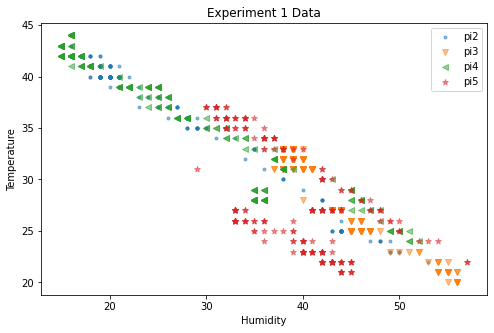

In [6]:
from visualising import visualise_experiment
visualise_experiment(sampled_data[1]["data"])

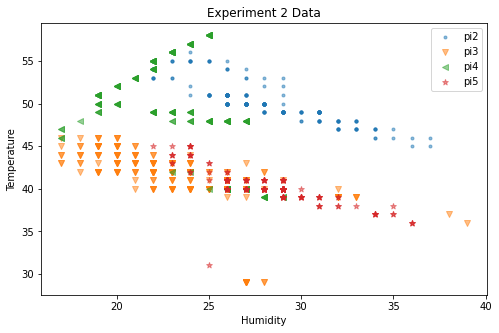

In [7]:
visualise_experiment(sampled_data[2]["data"])

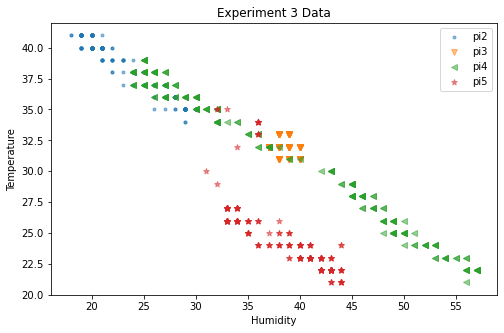

In [8]:
visualise_experiment(sampled_data[3]["data"])

## Similarity MMD

In [9]:
from maximum_mean_discrepancy import avg_similarity_disimilarity_MMD as ASDMMD
from prettytable import PrettyTable

def bandwidth_experiment(samples, similar_nodes, other_nodes, bandwidths, kernel):
    print(kernel.upper(), "\n")
    t = PrettyTable(['Bandwidth', 'Similarity MMD', 'Dissimilarity MMD'])
    for bandwidth in bandwidths:
        avg_sim_mmd, avg_dis_mmd, s, d = ASDMMD(samples, similar_nodes, other_nodes, kernel, bandwidth)
        t.add_row([bandwidth, avg_sim_mmd, avg_dis_mmd])
        print(s)
        print(d)
        print()
        
    print(t)
    print()

### Experiment 1

Nodes pi2 and pi4 are similar according to mmd and nodes pi3 and pi5 are similar to each other but not to the others

In [10]:
from maximum_mean_discrepancy import get_tensor_samples
tensor_samples = get_tensor_samples(sampled_data[1]["data"], sample_size=m)

In [11]:
similar_nodes = ["pi2","pi4"]
other_nodes = ["pi3","pi5"]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(1, 10, 5), "rbf")

LINEAR 

+----------------+--------------------+
|     Nodes      |    Similar MMD     |
+----------------+--------------------+
| ('pi2', 'pi4') | 2.0388641357421875 |
+----------------+--------------------+
+----------------+--------------------+
|     Nodes      |   Dissimilar MMD   |
+----------------+--------------------+
| ('pi3', 'pi2') | 35.446929931640625 |
| ('pi3', 'pi4') | 35.68244934082031  |
| ('pi5', 'pi2') | 26.60894775390625  |
| ('pi5', 'pi4') | 26.812850952148438 |
| ('pi3', 'pi5') |   3.822509765625   |
+----------------+--------------------+

+----------------+------------------+
|     Nodes      |   Similar MMD    |
+----------------+------------------+
| ('pi2', 'pi4') | 6.11651611328125 |
+----------------+------------------+
+----------------+--------------------+
|     Nodes      |   Dissimilar MMD   |
+----------------+--------------------+
| ('pi3', 'pi2') |   106.3408203125   |
| ('pi3', 'pi4') | 107.04754638671875 |
| ('pi5', 'pi2') |  79.826904296875   |


similar_sets = ["pi3", "pi5"]
dissimilar_sets = ["pi2", "pi4"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1, 10, 5), "rbf")

### Experiment 3

Nodes pi3, pi4, pi5 are dissimilar with pi2. Nodes pi3 and pi4 are similar to each other and similar to pi5.

In [12]:
tensor_samples = get_tensor_samples(sampled_data[3]["data"], sample_size=m)

In [13]:
similar_nodes = ["pi2", "pi4"]
other_nodes = ["pi3", "pi5"]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(1,5 , 4), "rbf")

LINEAR 

+----------------+--------------------+
|     Nodes      |    Similar MMD     |
+----------------+--------------------+
| ('pi2', 'pi4') | 30.900558471679688 |
| ('pi3', 'pi2') | 28.728729248046875 |
| ('pi3', 'pi4') | 2.6090240478515625 |
| ('pi5', 'pi4') | 6.4317474365234375 |
| ('pi3', 'pi5') |  7.85955810546875  |
+----------------+--------------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi5', 'pi2') | 44.160888671875 |
+----------------+-----------------+

+----------------+-------------------+
|     Nodes      |    Similar MMD    |
+----------------+-------------------+
| ('pi2', 'pi4') |   92.70166015625  |
| ('pi3', 'pi2') |  86.186279296875  |
| ('pi3', 'pi4') |  7.8270263671875  |
| ('pi5', 'pi4') | 19.29534912109375 |
| ('pi3', 'pi5') | 23.57867431640625 |
+----------------+-------------------+
+----------------+--------------------+
|     Nodes      |   Dissimilar MMD   |
+-------------

similar_sets = ["pi2", "pi3", "pi4"]
dissimilar_sets = ["pi5"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1,5 , 4), "rbf")

### Experiment 2

In [14]:
tensor_samples = get_tensor_samples(sampled_data[2]["data"], sample_size=m)

In [15]:
similar_nodes = ["pi3", "pi5"]
other_nodes = ["pi2", "pi4"]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(5,100 , 5), "rbf")

LINEAR 

+----------------+--------------------+
|     Nodes      |    Similar MMD     |
+----------------+--------------------+
| ('pi3', 'pi5') | 4.8838043212890625 |
+----------------+--------------------+
+----------------+--------------------+
|     Nodes      |   Dissimilar MMD   |
+----------------+--------------------+
| ('pi2', 'pi3') | 13.26214599609375  |
| ('pi2', 'pi5') | 12.940963745117188 |
| ('pi4', 'pi3') | 12.690093994140625 |
| ('pi4', 'pi5') | 17.444656372070312 |
| ('pi2', 'pi4') | 5.772369384765625  |
+----------------+--------------------+

+----------------+------------------+
|     Nodes      |   Similar MMD    |
+----------------+------------------+
| ('pi3', 'pi5') | 14.6514892578125 |
+----------------+------------------+
+----------------+-------------------+
|     Nodes      |   Dissimilar MMD  |
+----------------+-------------------+
| ('pi2', 'pi3') | 39.78643798828125 |
| ('pi2', 'pi5') | 38.82293701171875 |
| ('pi4', 'pi3') | 38.07012939453125 |
| ('pi

## Testing Hypothesis

In [5]:
from sklearn.preprocessing import StandardScaler
from visualising import visualise_train_test_data

def get_xy_data(data):
    x = data.humidity.values.astype(np.float32)
    y = data.temperature.values.astype(np.float32)
    return x, y

def get_model_data(node_data, standardised = False):
    model_data = {}
    
    if standardised:
        scaler = StandardScaler()
        scaler.fit(pd.concat(node_data)[["humidity", "temperature"]])
    
    for i in range(4):
        node = "pi"+str(i+2)
        if standardised:
            std_node = scaler.transform(node_data[i][["humidity", "temperature"]])
            model_data[node] = (std_node[:,0],std_node[:,1])
        else:
            model_data[node] = get_xy_data(node_data[i])
        
    return model_data

In [12]:
from modelling import fit_clf, score_clf

def test_in_pairs(similar_pairs, model_data, models):
    l = []
    for pair in similar_pairs:
        x = model_data[pair[0]]
        y = model_data[pair[1]]
        
        model_x = models[pair[0]]
        ex = fit_clf(model_x, x)
        exy = score_clf(model_x, y)

        model_y = models[pair[1]]
        ey = fit_clf(model_y, y)
        eyx = score_clf(model_y, x)       
        
        l.append(pd.DataFrame([{"model_node" : pair[1], "test_node" : pair[0], "discrepancy" : abs(ex-eyx)}]))
        l.append(pd.DataFrame([{"model_node" : pair[0], "test_node" : pair[1], "discrepancy" : abs(ey-exy)}]))
    return pd.concat(l)

In [33]:
from maximum_mean_discrepancy import get_tensor_samples, get_similar_pairs_mmd
from maximum_mean_discrepancy import avg_similarity_disimilarity_MMD as ASDMMD
from prettytable import PrettyTable
from node import get_similar_other_nodes_sets, get_similar_pairs_ocsvm, remove_outliers
from modelling import grid_search_models
from itertools import combinations as comb

def get_mmd_similar_pairs(experiment, kernel, kernel_bandwidth):
    node_data = sampled_data[experiment]["data"]
    
    tensor_samples = get_tensor_samples(node_data, sample_size=200)
    similar_nodes, other_nodes = get_similar_other_nodes_sets(experiment)
    asmmd = ASDMMD(tensor_samples, similar_nodes, other_nodes, kernel, kernel_bandwidth, return_tables = False)
    print(f"The average MMD between similar sets is {asmmd}")
    
    similar_pairs, similar_nodes = get_similar_pairs_mmd(node_data, asmmd, kernel, kernel_bandwidth)
    print(f"The following pairs of nodes were deemed similar {similar_pairs} using the MMD method.\n")
    
    return similar_pairs, similar_nodes

def get_ocsvm_similar_pairs(threshold, unidirectional = False):
    node_data = get_node_data(data, experiment, filtered = False)
    models = sampled_data[experiment]["models"]
    inliers =  sampled_data[experiment]["inliers"]
    similar_pairs, similar_nodes = get_similar_pairs_ocsvm(node_data, models, inliers, threshold, unidirectional)
    print(f"The following pairs of nodes were deemed similar {similar_pairs} using the OCSVM method.\n")
    
    return similar_pairs, similar_nodes

def select_model_data(node_data, similar_nodes, standardised):
    model_data = get_model_data(node_data, standardised)
    selected_model_data = {node : model_data[node] for node in similar_nodes}
    return selected_model_data

def get_similar_pairs_nodes(method, similar_pairs_args):
#     node_data = sampled_data[experiment]["data"]
    if method in ["mmd", "ocsvm"]:
        if method == "mmd":
            experiment, kernel, kernel_bandwidth = similar_pairs_args
            similar_pairs, similar_nodes = get_mmd_similar_pairs(experiment, kernel, kernel_bandwidth)
            node_data = sampled_data[experiment]
        elif method == "ocsvm":
            threshold, unidirectional = similar_pairs_args
            similar_pairs, similar_nodes = get_ocsvm_similar_pairs(threshold, unidirectional)
            
#         model_data = select_model_data(node_data, similar_nodes, standardised)
        
    elif method in ["both", "verify", "trio"]:
        threshold, unidirectional = similar_pairs_args[1]
        ocsvm_similar_pairs, ocsvm_similar_nodes = get_ocsvm_similar_pairs(threshold, unidirectional)

        experiment, kernel, kernel_bandwidth = similar_pairs_args[0]
        mmd_similar_pairs, mmd_similar_nodes = get_mmd_similar_pairs(experiment, kernel, kernel_bandwidth)
        
        if method in ["both", "trio"]:
            similar_pairs = [mmd_similar_pairs, ocsvm_similar_pairs]
            similar_nodes = [mmd_similar_nodes, ocsvm_similar_nodes]
            
#             mmd_model_data = select_model_data(node_data, mmd_similar_nodes, standardised)
#             ocsvm_model_data = select_model_data(node_data, ocsvm_similar_nodes, standardised)          
#             model_data = [mmd_model_data, ocsvm_model_data]
        
        if method in  ["verify", "trio"]:
            str_mmd_similar_pairs = str([pair[::-1] for pair in mmd_similar_pairs]) + str(mmd_similar_pairs)
            verify_similar_pairs = [pair for pair in ocsvm_similar_pairs if str(pair) in str_mmd_similar_pairs]
            verify_similar_nodes = [node for node in ocsvm_similar_nodes if node in str(verify_similar_pairs)]
            
#             verify_model_data = select_model_data(node_data, verify_similar_nodes, standardised)

            if method == "trio":
                similar_pairs.append(verify_similar_pairs)
                similar_nodes.append(verify_similar_nodes)
#                 model_data.append(verify_model_data)
            else:
                similar_pairs = verify_similar_pairs
                similar_nodes = verify_similar_nodes
#                 model_data = verify_model_data

    return similar_pairs, similar_nodes

def test_hypothesis(clf_name, model_data, similar_pairs, similar_nodes): 
    models, models_df = grid_search_models(clf_name, model_data, similar_nodes)
    test_df = test_in_pairs(similar_pairs, model_data, models)
    return models_df.merge(test_df, how='outer', on='model_node')
    
def test_hypothesis_all_clfs(experiment, similar_pairs, similar_nodes, standardised):
    model_data = select_model_data(sampled_data[experiment]["data"], similar_nodes, standardised)
    svr_df = test_hypothesis("svr", model_data, similar_pairs, similar_nodes)
    lsvr_df = test_hypothesis("lsvr", model_data, similar_pairs, similar_nodes)
    lreg_df = test_hypothesis("lreg", model_data, similar_pairs, similar_nodes)
    return pd.concat([svr_df, lsvr_df, lreg_df])

def test_hypothesis_all_methods_clfs(experiment, similar_pairs, similar_nodes):
    l = []
    for standardised in [True, False]:
        if not standardised:
            msg = " not"
        else:
            msg = ""
        print(f"The data{msg} are standardised: \n")
        print("Optimising models for MMD method and testing hypothesis.")
        mmd_df = test_hypothesis_all_clfs(experiment, similar_pairs[0], similar_nodes[0], standardised)
        mmd_df["method"] = ["MMD"] * mmd_df.shape[0]
        mmd_df["std"] = [standardised] * mmd_df.shape[0]
        l.append(mmd_df)
        
        print("Optimising models for OCSVM method and testing hypothesis.")
        ocsvm_df = test_hypothesis_all_clfs(experiment, similar_pairs[1], similar_nodes[1], standardised)
        ocsvm_df["method"] = ["OCSVM"] * ocsvm_df.shape[0]
        ocsvm_df["std"] = [standardised] * ocsvm_df.shape[0]
        l.append(ocsvm_df)
        
        if len(model_data[2]) != 0:
            print("Optimising models for MMD OCSVM verify method and testing hypothesis.")
            verify_df = test_hypothesis_all_clfs(experiment, similar_pairs[2], similar_nodes[2], standardised)
            verify_df["method"] = ["MMD OCSVM Verify"] * verify_df.shape[0]
            verify_df["std"] = [standardised] * verify_df.shape[0]
            l.append(verify_df)
        print()
            
    return pd.concat(l)

In [ ]:
similar_pairs, similar_nodes = get_similar_pairs_nodes("trio", similar_pairs_args = [(1, "linear", 0.5), (0.45, False)])
df = test_hypothesis_all_methods_clfs(1, similar_pairs, similar_nodes)

The following pairs of nodes were deemed similar [('pi2', 'pi4'), ('pi3', 'pi4')] using the OCSVM method.

The average MMD between similar sets is 11.0517578125
The following pairs of nodes were deemed similar [('pi2', 'pi4')] using the MMD method.

The data are standardised: 

Optimising models for MMD method and testing hypothesis.
Optimising models for OCSVM method and testing hypothesis.
Optimising models for MMD OCSVM verify method and testing hypothesis.
The data not are standardised: 

Optimising models for MMD method and testing hypothesis.


In [30]:
df

,model_node,model,score,test_node,discrepancy,method,std
0,pi2,"SVR(C=100, epsilon=0.01)",0.992356,pi4,0.085998,MMD,True
1,pi4,"SVR(C=100, epsilon=0.2)",0.964031,pi2,0.100028,MMD,True
0,pi2,SVR(kernel='linear'),0.988552,pi4,0.008332,MMD,True
1,pi4,SVR(kernel='linear'),0.934053,pi2,0.024701,MMD,True
0,pi2,LinearRegression(),0.988639,pi4,0.010616,MMD,True
1,pi4,LinearRegression(),0.938411,pi2,0.009705,MMD,True
0,pi2,"SVR(C=100, epsilon=0.01)",0.992356,pi4,0.085998,OCSVM,True
1,pi4,"SVR(C=100, epsilon=0.2)",0.964031,pi2,0.100028,OCSVM,True
2,pi4,"SVR(C=100, epsilon=0.2)",0.964031,pi3,0.363199,OCSVM,True
3,pi3,SVR(),0.979965,pi4,3.711765,OCSVM,True


In [28]:
model_data, similar_pairs, similar_nodes = get_data(2, "trio", similar_pairs_args = [("linear", 0.7), (0.45, False)], 
                                                   standardised=False)
test_hypothesis_all_methods_clfs(model_data, similar_pairs, similar_nodes)

The following pairs of nodes were deemed similar [('pi2', 'pi4'), ('pi3', 'pi4')] using the OCSVM method.

The average MMD between similar sets is 34.7684326171875
The following pairs of nodes were deemed similar [('pi3', 'pi5')] using the MMD method.

MMD Method 

Optimising Models... 

+------+----------------+--------------------+-------------------------+--------------------+
| Node | Baseline Model |     Baseline R     |     Optimised Model     | Optimised Model R  |
+------+----------------+--------------------+-------------------------+--------------------+
| pi3  |     SVR()      | 0.3811014791466254 |  SVR(C=1, epsilon=0.5)  | 0.4029375991672216 |
| pi5  |     SVR()      | 0.6624443518084087 | SVR(C=100, epsilon=0.2) | 0.6705147526539665 |
+------+----------------+--------------------+-------------------------+--------------------+
+------------+-----------+---------------------+
| Model Node | Test Node |     Discrepancy     |
+------------+-----------+---------------------+


In [40]:
model_data, similar_pairs, similar_nodes = get_data(2, "trio", similar_pairs_args = [("linear", 0.7), (0.45, False)], 
                                                   standardised=True)
test_hypothesis_all_methods_clfs(model_data, similar_pairs, similar_nodes)

The following pairs of nodes were deemed similar [('pi2', 'pi4'), ('pi3', 'pi4')] using the OCSVM method.

The average MMD between similar sets is 35.026611328125
The following pairs of nodes were deemed similar [('pi3', 'pi5')] using the MMD method.

MMD Method 

Optimising Models... 

+------+----------------+-------------------+-------------------------+--------------------+
| Node | Baseline Model |     Baseline R    |     Optimised Model     | Optimised Model R  |
+------+----------------+-------------------+-------------------------+--------------------+
| pi3  |     SVR()      | 0.503858844746723 | SVR(C=0.1, epsilon=0.2) | 0.4337138466197503 |
| pi5  |     SVR()      | 0.652049025434405 | SVR(C=10, epsilon=0.01) | 0.6618291110804161 |
+------+----------------+-------------------+-------------------------+--------------------+
+------------+-----------+--------------------+
| Model Node | Test Node |    Discrepancy     |
+------------+-----------+--------------------+
|    pi5  

In [32]:
model_data, similar_pairs, similar_nodes = get_data(3, "trio", similar_pairs_args = [("linear", 0.5), (0.45, False)], 
                                                   standardised=False)
test_hypothesis_all_methods_clfs(model_data, similar_pairs, similar_nodes)

The following pairs of nodes were deemed similar [('pi2', 'pi4'), ('pi3', 'pi4')] using the OCSVM method.

The average MMD between similar sets is 24.57452392578125
The following pairs of nodes were deemed similar [('pi3', 'pi4')] using the MMD method.

MMD Method 

Optimising Models... 

+------+----------------+--------------------+--------------------------+---------------------+
| Node | Baseline Model |     Baseline R     |     Optimised Model      |  Optimised Model R  |
+------+----------------+--------------------+--------------------------+---------------------+
| pi3  |     SVR()      | 0.0770690042964639 | SVR(C=0.1, epsilon=0.2)  | 0.12051726863570589 |
| pi4  |     SVR()      | 0.9887995345905477 | SVR(C=100, epsilon=0.01) |  0.9901820331403585 |
+------+----------------+--------------------+--------------------------+---------------------+
+------------+-----------+--------------------+
| Model Node | Test Node |    Discrepancy     |
+------------+-----------+------------

+------------+-----------+--------------------+
| Model Node | Test Node |    Discrepancy     |
+------------+-----------+--------------------+
|    pi4     |    pi3    | 2.106100791236486  |
|    pi3     |    pi4    | 0.5724739430476724 |
+------------+-----------+--------------------+

Optimising Models... 

+------+--------------------+---------------------+----------------------------------+----------------------+
| Node |   Baseline Model   |      Baseline R     |         Optimised Model          |  Optimised Model R   |
+------+--------------------+---------------------+----------------------------------+----------------------+
| pi4  | LinearRegression() |  0.9867399674611098 | LinearRegression(normalize=True) |  0.9867399697665156  |
| pi3  | LinearRegression() | 0.02989916265257564 | LinearRegression(normalize=True) | 0.029898601569873673 |
+------+--------------------+---------------------+----------------------------------+----------------------+
+------------+-----------+--

In [41]:
model_data, similar_pairs, similar_nodes = get_data(3, "trio", similar_pairs_args = [("linear", 0.5), (0.45, False)], 
                                                   standardised=True)
test_hypothesis_all_methods_clfs(model_data, similar_pairs, similar_nodes)

The following pairs of nodes were deemed similar [('pi2', 'pi4'), ('pi3', 'pi4')] using the OCSVM method.

The average MMD between similar sets is 23.65399169921875
The following pairs of nodes were deemed similar [('pi3', 'pi4')] using the MMD method.

MMD Method 

Optimising Models... 

+------+----------------+---------------------+-------------------------+---------------------+
| Node | Baseline Model |      Baseline R     |     Optimised Model     |  Optimised Model R  |
+------+----------------+---------------------+-------------------------+---------------------+
| pi3  |     SVR()      | 0.08258791646327879 |        SVR(C=0.1)       | 0.08257271802949162 |
| pi4  |     SVR()      |  0.9891197959484355 | SVR(C=10, epsilon=0.01) |  0.9902422984092918 |
+------+----------------+---------------------+-------------------------+---------------------+
+------------+-----------+--------------------+
| Model Node | Test Node |    Discrepancy     |
+------------+-----------+------------